In [1]:
#Setting up prerequisites
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from sklearn.metrics import mean_squared_error

from numpy import matrix

print("Setup Complete\n")

Setup Complete



In [2]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations,R_base):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.R_base=R_base

    def train(self):
        # Create and initialize P and Q matrices with random values
        
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))
        
        
        """
        np.random.normal return the array of specified size by allocating random values according to the Gaussian (Normal) 
        distribution with (mean = loc , SD = scale). By default mean=0.
        
        Helpful link : https://www.geeksforgeeks.org/rand-vs-normal-numpy-random-python/
        
        """

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        #(np.where(self.R != 0)) -> returns two lists M,N where Mi,Ni are row and coulmn of non-zero elements.

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R_base[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        mse=0.0
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            x=self.sgd()
            mse1=mse
            mse = self.mse()
            if i!=0 and mse > mse1+3:
                print("optimality reached at Iteration : %d" % (i))
                break
            training_process.append((i, mse))
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R_base.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        e=0.0
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e1=e
            e = (r - prediction)
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2* e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (2 * e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [3]:
class Stack:
     def __init__(self,items):
         self.items = items

     def isEmpty(self):
         return self.items == []

     def push(self, item):
         self.items.append(item)

     def pop(self):
         return self.items.pop()

     def peek(self):
         return self.items[len(self.items)-1]

     def size(self):
         return len(self.items)

In [4]:
stackFactors1=Stack([10])
stackIterations1=Stack([50])
stackLearnRate1=Stack([0.01])
stackRegularions1=Stack([0.01])

In [5]:
### Using Movielens 100K dataset for the training and testing ##

dataFile=r"D:\Academics\7th sem\Data sciences\Project\ml-100k\u.data"
colNames=['UserID','MovieID','Rating','TimeStamp']
data=pd.read_csv(dataFile,sep="\t",names=colNames,header=None)
data.head()
#data.shape[0]

,UserID,MovieID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
###  Dropping timestamp as its unnecessary in this context  ###
data = data.drop(data.columns[[3]], axis=1)
data.head()

,UserID,MovieID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [7]:
"""
Converting the ratings to matrix form such that
R[User_ID][Movie_ID] = <rating given>

"""
mat=data.pivot(*data.columns)
R=np.asarray(mat)
print(R[:10,:10]) 

[[ 5.  3.  4.  3.  3.  5.  4.  1.  5.  3.]
 [ 4. nan nan nan nan nan nan nan nan  2.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 4.  3. nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan  2.  4.  4. nan]
 [nan nan nan  5. nan nan  5.  5.  5.  4.]
 [nan nan nan nan nan nan  3. nan nan nan]
 [nan nan nan nan nan  5.  4. nan nan nan]
 [ 4. nan nan  4. nan nan  4. nan  4. nan]]


In [10]:
"""
Since some of the users may not rate some movies, we have nan values after converting to matrix form
We convert all those nan values to 0

"""

R=np.nan_to_num(R)
#[:200,:200]
R=np.float64(R) #for calculation purpose
R1=R
R[:10,:10]

array([[5., 3., 4., 3., 3., 5., 4., 1., 5., 3.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 2., 4., 4., 0.],
       [0., 0., 0., 5., 0., 0., 5., 5., 5., 4.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 4., 0., 0., 0.],
       [4., 0., 0., 4., 0., 0., 4., 0., 4., 0.]])

In [11]:
MAE_normalMF=[]
MAE_DeepMF=[]


for observations in range(10):
    print("######################## Iteration-%d ###########"% (observations+1))
    print()
    print()
    print("################# MF ######################")
    print()
    stackFactors1=Stack([10])
    stackIterations1=Stack([200])
    stackLearnRate1=Stack([0.01])
    stackRegularions1=Stack([0.01])
    """
    We try to analyze the efficiency(based on MAE) of base Matrix Factorization and Deep Matrix Factorization 
    with the same training and testing sets. For that we try to divide the dataset into 70:30
    ratios for training and testing respectively.We divide randomly and then make those values 0's and then try
    to find these values based on training dataset.

    """
    prop_i = int(min(R.shape[0],R.shape[1])*0.3)
    prop_j = int(R.shape[1] * 0.2)
    #print(R.size)
    R1=R
    R1=np.rint(R1)

    #Randomly choose indices of the numpy array:
    i = [np.random.choice(range(R.shape[0])) for _ in range(prop_i)]
    j = [np.random.choice(range(R.shape[1])) for _ in range(prop_i)]

    R1[i,j]=0

    #print(len(i))
    #print(len(j))


    print("Original:\n",R)
    print("Test Set:\n",R1)
    R=np.rint(R)
    u,v=R.shape
    Res=np.zeros([u,v])
    xs, ys = R.nonzero()


    k=stackFactors1.pop()
    t=stackIterations1.pop()
    alppa=stackLearnRate1.pop()
    betta=stackRegularions1.pop()

    mf = MF(R1, K=k, alpha=alppa, beta=betta, iterations=t,R_base=R1)

    training_process = mf.train()

    print()
    print("P x Q:")
    print(mf.full_matrix())


    predicted = mf.full_matrix()
    for x, y in zip(xs, ys):
        R1[x,y]= mf.R[x, y] - predicted[x, y]
    for t in range(len(Res)):  
        for p in range(len(Res[0])):
            Res[t][p] = Res[t][p] + predicted[t,p]
    print()
    print()

    print()
    print()
    print("Final result is :")
    Res=np.rint(Res)
    for t in range(Res.shape[0]):
        for p in range(Res.shape[1]):
            if Res[t,p]>5:
                Res[t,p]=5
            if Res[t,p]<1:
                Res[t,p]=1
    print(Res)
    print()
    print()
    msef=0.0
    c=int(0)
    for i1 in range(len(i)):
        for i2 in range(len(j)):
            if R.item(i[i1],j[i2])!=0:
                #print(i1,i2)
                msef = msef + abs(R.item((i[i1],j[i2]))-(Res).item((i[i1],j[i2])))
                c=c+1
    msef = (msef/c)
    MAE_normalMF.append(msef)
    print("MAE = ",msef)
    print()
    print()








    print("################# DeepMF ######################") 
    stackFactors=Stack([10,10,10,10])
    stackIterations=Stack([50,50,50,50])
    stackLearnRate=Stack([0.01,0.01,0.01,0.01])
    stackRegularions=Stack([0.01,0.01,0.01,0.01])

    R1=R
    R1[i,j]=0

    #print("Original:\n",R)
    #print("Test Set:\n",R1)
    R=np.rint(R)
    u,v=R.shape
    Res=np.zeros([u,v])

    p=stackFactors.size()+1
    for it in range(1,p):
        k=stackFactors.pop()
        t=stackIterations.pop()
        alppa=stackLearnRate.pop()
        betta=stackRegularions.pop()

        mf = MF(R1, K=k, alpha=alppa, beta=betta, iterations=t,R_base=R)

        training_process = mf.train()

        print()
        print("P x Q:")
        print(mf.full_matrix())

        xs, ys = mf.R_base.nonzero()
        predicted = mf.full_matrix()
        for x, y in zip(xs, ys):
            R1[x,y]= mf.R[x, y] - predicted[x, y]
        for t in range(len(Res)):  
            for p in range(len(Res[0])):
                Res[t][p] = Res[t][p] + predicted[t,p]
        print()
        print()

    print()
    print()
    print("Final result is :")
    Res=np.rint(Res)
    for p in range(Res.shape[0]):
        for t in range(Res.shape[1]):
            if Res[p,t]>5:
                Res[p,t]=5
            if Res[p,t]<1:
                Res[p,t]=1
    print(Res)
    print()
    print()

    msef=0.0
    c=int(0)
    for i1 in range(len(i)):
        for i2 in range(len(j)):
            if R.item(i[i1],j[i2])!=0:
                #print(i1,i2)
                msef = msef + abs(R.item((i[i1],j[i2]))-(Res).item((i[i1],j[i2])))
                c=c+1
    msef = (msef/c)
    print("MAE_DeepMF = ",msef)
    MAE_DeepMF.append(msef)
    print()
    print()

######################## Iteration-1 ###########


################# MF ######################

Original:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Test Set:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Iteration: 1 ; error = 302.2469
Iteration: 2 ; error = 293.9122
Iteration: 3 ; error = 287.5570
Iteration: 4 ; error = 279.4190
Iteration: 5 ; error = 270.2588
Iteration: 6 ; error = 262.0565
Iteration: 7 ; error = 255.1216
Iteration: 8 ; error = 249.6422
Iteration: 9 ; error = 245.2040
Iteration: 10 ; error = 241.6279
Iteration: 11 ; error = 238.7351
Iteration: 12 ; error = 236.2583
Iteration: 13 ; error = 234.2437
Iteration: 14 ; error = 232.5195
Iteration: 15 ; error = 230.9983
Iteration: 16 ; error = 229.7169
Iteration: 17 ; error = 228.6102
Iteration: 18 ; er

Iteration: 34 ; error = 220.8779
Iteration: 35 ; error = 220.5840
Iteration: 36 ; error = 220.4367
Iteration: 37 ; error = 220.1685
Iteration: 38 ; error = 220.0687
Iteration: 39 ; error = 219.8979
Iteration: 40 ; error = 219.7163
Iteration: 41 ; error = 219.5144
Iteration: 42 ; error = 219.3152
Iteration: 43 ; error = 219.1895
Iteration: 44 ; error = 219.0498
Iteration: 45 ; error = 218.9284
Iteration: 46 ; error = 218.7699
Iteration: 47 ; error = 218.6910
Iteration: 48 ; error = 218.5700
Iteration: 49 ; error = 218.3699
Iteration: 50 ; error = 218.3938

P x Q:
[[3.62365792 2.96365481 4.23608604 ... 3.2982197  3.72293753 3.3265858 ]
 [4.31370582 3.15498328 2.23686708 ... 3.4723588  3.67068459 3.26883483]
 [4.07598671 2.67026607 1.42556891 ... 2.67123181 2.80912971 2.66301188]
 ...
 [4.51594071 3.53902537 2.74019737 ... 3.82823417 3.93626083 3.8225457 ]
 [4.28514305 3.45875643 3.56059753 ... 4.04099241 3.98279508 3.78223934]
 [4.49957984 3.69795151 0.79642743 ... 2.76005604 3.11950963 

Iteration: 5 ; error = 270.0546
Iteration: 6 ; error = 261.8036
Iteration: 7 ; error = 254.8750
Iteration: 8 ; error = 249.3009
Iteration: 9 ; error = 244.9634
Iteration: 10 ; error = 241.4967
Iteration: 11 ; error = 238.7191
Iteration: 12 ; error = 236.2523
Iteration: 13 ; error = 234.3256
Iteration: 14 ; error = 232.5991
Iteration: 15 ; error = 231.2118
Iteration: 16 ; error = 229.9321
Iteration: 17 ; error = 228.8757
Iteration: 18 ; error = 227.8103
Iteration: 19 ; error = 226.9418
Iteration: 20 ; error = 226.2535
Iteration: 21 ; error = 225.5737
Iteration: 22 ; error = 224.8716
Iteration: 23 ; error = 224.2746
Iteration: 24 ; error = 223.7197
Iteration: 25 ; error = 223.3390
Iteration: 26 ; error = 222.8064
Iteration: 27 ; error = 222.4201
Iteration: 28 ; error = 222.0182
Iteration: 29 ; error = 221.7586
Iteration: 30 ; error = 221.3922
Iteration: 31 ; error = 221.1374
Iteration: 32 ; error = 220.8853
Iteration: 33 ; error = 220.5769
Iteration: 34 ; error = 220.2879
Iteration: 35 ;

Iteration: 44 ; error = 218.6357
Iteration: 45 ; error = 218.5054
Iteration: 46 ; error = 218.3821
Iteration: 47 ; error = 218.3048
Iteration: 48 ; error = 218.1372
Iteration: 49 ; error = 218.0661
Iteration: 50 ; error = 218.0115

P x Q:
[[ 3.65358477  3.30532113  4.05086757 ...  3.05049402  3.42656962
   3.19273876]
 [ 3.8413748   3.42149215  1.67360484 ...  3.26402394  3.62009744
   3.51797807]
 [ 4.24575026  3.28474583 -0.54329266 ...  2.66190501  2.87746777
   2.75546709]
 ...
 [ 4.82476804  4.2679581   3.24358989 ...  3.78525791  4.02162246
   3.80801293]
 [ 4.74682938  4.08711412  3.58892152 ...  3.68962721  3.96292198
   3.89723929]
 [ 4.30192796  3.76284787  2.42596233 ...  2.80562361  3.3707741
   3.07676417]]


Iteration: 1 ; error = 217.0954
Iteration: 2 ; error = 216.2060
Iteration: 3 ; error = 215.1472
Iteration: 4 ; error = 213.6683
Iteration: 5 ; error = 211.6618
Iteration: 6 ; error = 209.2186
Iteration: 7 ; error = 206.5776
Iteration: 8 ; error = 203.8740
Iteration: 9

Iteration: 14 ; error = 232.8719
Iteration: 15 ; error = 231.3557
Iteration: 16 ; error = 230.1005
Iteration: 17 ; error = 228.9361
Iteration: 18 ; error = 227.9313
Iteration: 19 ; error = 227.0663
Iteration: 20 ; error = 226.2082
Iteration: 21 ; error = 225.5084
Iteration: 22 ; error = 224.8491
Iteration: 23 ; error = 224.3132
Iteration: 24 ; error = 223.6729
Iteration: 25 ; error = 223.1560
Iteration: 26 ; error = 222.7404
Iteration: 27 ; error = 222.3791
Iteration: 28 ; error = 221.9657
Iteration: 29 ; error = 221.6306
Iteration: 30 ; error = 221.2789
Iteration: 31 ; error = 220.9245
Iteration: 32 ; error = 220.6980
Iteration: 33 ; error = 220.4568
Iteration: 34 ; error = 220.1323
Iteration: 35 ; error = 219.8921
Iteration: 36 ; error = 219.7055
Iteration: 37 ; error = 219.5083
Iteration: 38 ; error = 219.2800
Iteration: 39 ; error = 219.0849
Iteration: 40 ; error = 218.9098
Iteration: 41 ; error = 218.7992
Iteration: 42 ; error = 218.6074
Iteration: 43 ; error = 218.4658
Iteration:



Iteration: 1 ; error = 217.2392
Iteration: 2 ; error = 216.4126
Iteration: 3 ; error = 215.2714
Iteration: 4 ; error = 213.7224
Iteration: 5 ; error = 211.6804
Iteration: 6 ; error = 209.1184
Iteration: 7 ; error = 206.3920
Iteration: 8 ; error = 203.6749
Iteration: 9 ; error = 201.2572
Iteration: 10 ; error = 199.1852
Iteration: 11 ; error = 197.4100
Iteration: 12 ; error = 195.8704
Iteration: 13 ; error = 194.6049
Iteration: 14 ; error = 193.5142
Iteration: 15 ; error = 192.4980
Iteration: 16 ; error = 191.6429
Iteration: 17 ; error = 190.8662
Iteration: 18 ; error = 190.1673
Iteration: 19 ; error = 189.5933
Iteration: 20 ; error = 189.0189
Iteration: 21 ; error = 188.5428
Iteration: 22 ; error = 188.0766
Iteration: 23 ; error = 187.6585
Iteration: 24 ; error = 187.2671
Iteration: 25 ; error = 186.9256
Iteration: 26 ; error = 186.6214
Iteration: 27 ; error = 186.3205
Iteration: 28 ; error = 186.0460
Iteration: 29 ; error = 185.7781
Iteration: 30 ; error = 185.5450
Iteration: 31 ; e

Iteration: 31 ; error = 221.8948
Iteration: 32 ; error = 221.5890
Iteration: 33 ; error = 221.4265
Iteration: 34 ; error = 221.0652
Iteration: 35 ; error = 220.8959
Iteration: 36 ; error = 220.6673
Iteration: 37 ; error = 220.4238
Iteration: 38 ; error = 220.1728
Iteration: 39 ; error = 220.0203
Iteration: 40 ; error = 219.8124
Iteration: 41 ; error = 219.6631
Iteration: 42 ; error = 219.5367
Iteration: 43 ; error = 219.3636
Iteration: 44 ; error = 219.2099
Iteration: 45 ; error = 219.0667
Iteration: 46 ; error = 218.9491
Iteration: 47 ; error = 218.7881
Iteration: 48 ; error = 218.5427
Iteration: 49 ; error = 218.4556
Iteration: 50 ; error = 218.4083
Iteration: 51 ; error = 218.3473
Iteration: 52 ; error = 218.1991
Iteration: 53 ; error = 218.1446
Iteration: 54 ; error = 218.1082
Iteration: 55 ; error = 217.9217
Iteration: 56 ; error = 217.8538
Iteration: 57 ; error = 217.7797
Iteration: 58 ; error = 217.6782
Iteration: 59 ; error = 217.6923
Iteration: 60 ; error = 217.6494
Iteration:

Iteration: 36 ; error = 183.8331
Iteration: 37 ; error = 183.6329
Iteration: 38 ; error = 183.4810
Iteration: 39 ; error = 183.3121
Iteration: 40 ; error = 183.1971
Iteration: 41 ; error = 183.0568
Iteration: 42 ; error = 182.9179
Iteration: 43 ; error = 182.7718
Iteration: 44 ; error = 182.6736
Iteration: 45 ; error = 182.5874
Iteration: 46 ; error = 182.4502
Iteration: 47 ; error = 182.3744
Iteration: 48 ; error = 182.2482
Iteration: 49 ; error = 182.1986
Iteration: 50 ; error = 182.0994

P x Q:
[[ 0.52440559  0.05207369 -0.05385369 ... -0.08384128 -0.21105111
  -0.21559207]
 [ 0.15924217  0.3316135   0.15006187 ... -0.05057178 -0.10438007
  -0.07826187]
 [-0.44988553 -1.29073206  0.20990185 ...  0.0737842   0.101992
  -0.21038207]
 ...
 [-0.50059205  0.1620939  -0.03363254 ... -0.2659352  -0.29708212
  -0.10721814]
 [ 0.12648921  0.4986374   0.10570094 ... -0.10418528 -0.0451868
  -0.00694571]
 [ 0.53145406  1.28924641 -0.03110926 ...  0.0766023  -0.07467846
   0.10993579]]


Iterat

Iteration: 71 ; error = 216.4621
Iteration: 72 ; error = 216.5024
Iteration: 73 ; error = 216.2795
Iteration: 74 ; error = 216.3305
Iteration: 75 ; error = 216.2170
Iteration: 76 ; error = 216.3061
Iteration: 77 ; error = 216.1629
Iteration: 78 ; error = 216.2674
Iteration: 79 ; error = 216.1148
Iteration: 80 ; error = 216.0944
Iteration: 81 ; error = 216.0153
Iteration: 82 ; error = 216.1420
Iteration: 83 ; error = 215.9685
Iteration: 84 ; error = 216.0120
Iteration: 85 ; error = 216.1600
Iteration: 86 ; error = 215.9895
Iteration: 87 ; error = 215.8654
Iteration: 88 ; error = 215.8724
Iteration: 89 ; error = 215.9481
Iteration: 90 ; error = 215.8669
Iteration: 91 ; error = 215.9036
Iteration: 92 ; error = 215.9770
Iteration: 93 ; error = 216.0381
Iteration: 94 ; error = 215.9169
Iteration: 95 ; error = 215.8746
Iteration: 96 ; error = 215.9374
Iteration: 97 ; error = 215.7596
Iteration: 98 ; error = 215.9061
Iteration: 99 ; error = 215.9696
Iteration: 100 ; error = 215.7601
Iteration



Iteration: 1 ; error = 181.9704
Iteration: 2 ; error = 181.3257
Iteration: 3 ; error = 180.5672
Iteration: 4 ; error = 179.6421
Iteration: 5 ; error = 178.4714
Iteration: 6 ; error = 176.9308
Iteration: 7 ; error = 175.2492
Iteration: 8 ; error = 173.3576
Iteration: 9 ; error = 171.5597
Iteration: 10 ; error = 169.8538
Iteration: 11 ; error = 168.3601
Iteration: 12 ; error = 167.0483
Iteration: 13 ; error = 165.9350
Iteration: 14 ; error = 164.9554
Iteration: 15 ; error = 164.1047
Iteration: 16 ; error = 163.3411
Iteration: 17 ; error = 162.6652
Iteration: 18 ; error = 162.1074
Iteration: 19 ; error = 161.5485
Iteration: 20 ; error = 161.0845
Iteration: 21 ; error = 160.6780
Iteration: 22 ; error = 160.2681
Iteration: 23 ; error = 159.9535
Iteration: 24 ; error = 159.6114
Iteration: 25 ; error = 159.3463
Iteration: 26 ; error = 159.0662
Iteration: 27 ; error = 158.8136
Iteration: 28 ; error = 158.5663
Iteration: 29 ; error = 158.3721
Iteration: 30 ; error = 158.1496
Iteration: 31 ; e

Iteration: 101 ; error = 215.8625
Iteration: 102 ; error = 215.9510
Iteration: 103 ; error = 215.9527
Iteration: 104 ; error = 216.0221
Iteration: 105 ; error = 215.9705
Iteration: 106 ; error = 215.9057
Iteration: 107 ; error = 216.0245
Iteration: 108 ; error = 215.9302
Iteration: 109 ; error = 215.7926
Iteration: 110 ; error = 215.9103
Iteration: 111 ; error = 216.0696
Iteration: 112 ; error = 215.9800
Iteration: 113 ; error = 216.0836
Iteration: 114 ; error = 215.9957
Iteration: 115 ; error = 215.9319
Iteration: 116 ; error = 215.9962
Iteration: 117 ; error = 216.1425
Iteration: 118 ; error = 216.1588
Iteration: 119 ; error = 216.0800
Iteration: 120 ; error = 216.1097
Iteration: 121 ; error = 215.8964
Iteration: 122 ; error = 215.9522
Iteration: 123 ; error = 216.0298
Iteration: 124 ; error = 216.1299
Iteration: 125 ; error = 215.9765
Iteration: 126 ; error = 216.2833
Iteration: 127 ; error = 216.0502
Iteration: 128 ; error = 216.0613
Iteration: 129 ; error = 216.2296
Iteration: 130

Iteration: 45 ; error = 155.8683
Iteration: 46 ; error = 155.7776
Iteration: 47 ; error = 155.7056
Iteration: 48 ; error = 155.6362
Iteration: 49 ; error = 155.5228
Iteration: 50 ; error = 155.4649

P x Q:
[[ 0.0066901  -0.21615921  0.18647719 ... -0.31748768 -0.05255132
  -0.13230506]
 [ 0.23882023  0.15453028 -0.36452314 ... -0.02158269  0.04490816
   0.03145877]
 [ 0.08234934  0.54918765  0.45440648 ... -0.12881612 -0.11438491
  -0.05483089]
 ...
 [-0.24038881 -0.04938475  0.02824549 ... -0.10367778 -0.17986012
  -0.13646641]
 [-0.25197767 -0.11793697 -0.10633803 ...  0.0306557   0.04095152
  -0.00147238]
 [-0.52497237 -0.16117665 -0.17416194 ...  0.27734227  0.10724606
   0.04505782]]


Iteration: 1 ; error = 155.1761
Iteration: 2 ; error = 154.6242
Iteration: 3 ; error = 154.0761
Iteration: 4 ; error = 153.4293
Iteration: 5 ; error = 152.6749
Iteration: 6 ; error = 151.7074
Iteration: 7 ; error = 150.5858
Iteration: 8 ; error = 149.3321
Iteration: 9 ; error = 147.9869
Iteration: 1

Iteration: 139 ; error = 216.1304
Iteration: 140 ; error = 216.1773
Iteration: 141 ; error = 216.0864
Iteration: 142 ; error = 216.0775
Iteration: 143 ; error = 216.2507
Iteration: 144 ; error = 216.2736
Iteration: 145 ; error = 216.1540
Iteration: 146 ; error = 216.1560
Iteration: 147 ; error = 216.3795
Iteration: 148 ; error = 216.4653
Iteration: 149 ; error = 216.3017
Iteration: 150 ; error = 216.3241
Iteration: 151 ; error = 216.2055
Iteration: 152 ; error = 216.4017
Iteration: 153 ; error = 216.2605
Iteration: 154 ; error = 216.5112
Iteration: 155 ; error = 216.3617
Iteration: 156 ; error = 216.5656
Iteration: 157 ; error = 216.6998
Iteration: 158 ; error = 216.5406
Iteration: 159 ; error = 216.4354
Iteration: 160 ; error = 216.5491
Iteration: 161 ; error = 216.8915
Iteration: 162 ; error = 216.5144
Iteration: 163 ; error = 217.0372
Iteration: 164 ; error = 216.6459
Iteration: 165 ; error = 216.4957
Iteration: 166 ; error = 216.7390
Iteration: 167 ; error = 216.7879
Iteration: 168

Iteration: 36 ; error = 157.2612
Iteration: 37 ; error = 157.1338
Iteration: 38 ; error = 157.0157
Iteration: 39 ; error = 156.8907
Iteration: 40 ; error = 156.7707
Iteration: 41 ; error = 156.7077
Iteration: 42 ; error = 156.5584
Iteration: 43 ; error = 156.4617
Iteration: 44 ; error = 156.3664
Iteration: 45 ; error = 156.2714
Iteration: 46 ; error = 156.2020
Iteration: 47 ; error = 156.1327
Iteration: 48 ; error = 156.0348
Iteration: 49 ; error = 155.9516
Iteration: 50 ; error = 155.8953

P x Q:
[[ 0.31297223 -0.25927163 -0.11776199 ... -0.0669173   0.12638396
   0.0459355 ]
 [ 0.8460972  -0.42657037 -0.38464581 ...  0.15300626  0.10520104
   0.25450173]
 [-0.18461479  0.25840302 -0.03513107 ... -0.04165471  0.05657801
  -0.0926612 ]
 ...
 [ 0.45542135  0.41048008  0.01317664 ... -0.22191246  0.25721414
  -0.09203493]
 [-0.29942323  0.47662037  0.22857009 ...  0.03241795  0.05865238
  -0.0365131 ]
 [-0.05472958  0.0410654  -0.1717303  ... -0.08728443  0.12989052
   0.05356575]]


Ite

Iteration: 134 ; error = 216.1199
Iteration: 135 ; error = 216.0223
Iteration: 136 ; error = 216.3311
Iteration: 137 ; error = 216.1108
Iteration: 138 ; error = 216.1960
Iteration: 139 ; error = 216.2005
Iteration: 140 ; error = 216.0989
Iteration: 141 ; error = 216.1639
Iteration: 142 ; error = 216.1694
Iteration: 143 ; error = 216.2548
Iteration: 144 ; error = 216.3825
Iteration: 145 ; error = 216.2610
Iteration: 146 ; error = 216.3503
Iteration: 147 ; error = 216.3317
Iteration: 148 ; error = 216.3061
Iteration: 149 ; error = 216.5217
Iteration: 150 ; error = 216.6373
Iteration: 151 ; error = 216.6047
Iteration: 152 ; error = 216.3036
Iteration: 153 ; error = 216.2359
Iteration: 154 ; error = 216.6821
Iteration: 155 ; error = 216.3368
Iteration: 156 ; error = 216.6233
Iteration: 157 ; error = 216.4287
Iteration: 158 ; error = 216.4935
Iteration: 159 ; error = 216.6109
Iteration: 160 ; error = 216.6633
Iteration: 161 ; error = 216.4916
Iteration: 162 ; error = 216.5023
Iteration: 163

Iteration: 31 ; error = 157.7306
Iteration: 32 ; error = 157.5116
Iteration: 33 ; error = 157.3602
Iteration: 34 ; error = 157.1747
Iteration: 35 ; error = 157.0094
Iteration: 36 ; error = 156.8976
Iteration: 37 ; error = 156.7271
Iteration: 38 ; error = 156.6137
Iteration: 39 ; error = 156.4775
Iteration: 40 ; error = 156.3778
Iteration: 41 ; error = 156.2894
Iteration: 42 ; error = 156.1544
Iteration: 43 ; error = 156.0700
Iteration: 44 ; error = 155.9560
Iteration: 45 ; error = 155.8753
Iteration: 46 ; error = 155.7552
Iteration: 47 ; error = 155.7015
Iteration: 48 ; error = 155.6206
Iteration: 49 ; error = 155.5201
Iteration: 50 ; error = 155.4781

P x Q:
[[ 0.2556887   0.220185    0.40153972 ...  0.12879152 -0.09991489
  -0.08205412]
 [ 0.01533314 -0.20456913  0.25668105 ...  0.04752751 -0.02225167
   0.06009802]
 [ 0.68057346  0.27782089 -0.18268145 ... -0.01357626 -0.10905837
  -0.19948115]
 ...
 [-0.24573024 -0.08341278  0.29226651 ... -0.08249053 -0.07431355
  -0.10087015]
 [ 

Iteration: 130 ; error = 216.1539
Iteration: 131 ; error = 215.9707
Iteration: 132 ; error = 216.2277
Iteration: 133 ; error = 216.1936
Iteration: 134 ; error = 216.0995
Iteration: 135 ; error = 216.3709
Iteration: 136 ; error = 216.1517
Iteration: 137 ; error = 216.2194
Iteration: 138 ; error = 216.1898
Iteration: 139 ; error = 216.2822
Iteration: 140 ; error = 216.4587
Iteration: 141 ; error = 216.3259
Iteration: 142 ; error = 216.1568
Iteration: 143 ; error = 216.4284
Iteration: 144 ; error = 216.4476
Iteration: 145 ; error = 216.6523
Iteration: 146 ; error = 216.4618
Iteration: 147 ; error = 216.5011
Iteration: 148 ; error = 216.2170
Iteration: 149 ; error = 216.7630
Iteration: 150 ; error = 216.4630
Iteration: 151 ; error = 216.8570
Iteration: 152 ; error = 216.7281
Iteration: 153 ; error = 216.5774
Iteration: 154 ; error = 216.8438
Iteration: 155 ; error = 216.9257
Iteration: 156 ; error = 216.8651
Iteration: 157 ; error = 216.8054
Iteration: 158 ; error = 216.9874
Iteration: 159

Iteration: 42 ; error = 156.4681
Iteration: 43 ; error = 156.3471
Iteration: 44 ; error = 156.2506
Iteration: 45 ; error = 156.1571
Iteration: 46 ; error = 156.0979
Iteration: 47 ; error = 155.9943
Iteration: 48 ; error = 155.9405
Iteration: 49 ; error = 155.8641
Iteration: 50 ; error = 155.7806

P x Q:
[[-0.00764156 -0.58927209  0.30811157 ... -0.09769434 -0.12269687
  -0.09339058]
 [-0.17138678  0.80842712  0.02441628 ...  0.15850256  0.25370612
   0.08296996]
 [ 0.43148029 -0.10283888 -0.04137442 ... -0.10552685 -0.04573597
  -0.09542398]
 ...
 [ 0.14072449  0.09416742 -0.1935048  ... -0.01109314 -0.01252004
  -0.0670952 ]
 [-0.18099489  0.22614498 -0.12373417 ...  0.01266776  0.05657439
  -0.16884795]
 [ 0.175596    0.1120114   0.01790202 ... -0.15827554 -0.10127261
   0.00647759]]


Iteration: 1 ; error = 155.4742
Iteration: 2 ; error = 154.9278
Iteration: 3 ; error = 154.3503
Iteration: 4 ; error = 153.6964
Iteration: 5 ; error = 152.8594
Iteration: 6 ; error = 151.8618
Iteration

Iteration: 140 ; error = 215.7778
Iteration: 141 ; error = 215.8067
Iteration: 142 ; error = 215.6774
Iteration: 143 ; error = 215.8930
Iteration: 144 ; error = 215.8235
Iteration: 145 ; error = 215.8653
Iteration: 146 ; error = 216.1137
Iteration: 147 ; error = 215.7756
Iteration: 148 ; error = 215.9487
Iteration: 149 ; error = 216.0967
Iteration: 150 ; error = 215.9603
Iteration: 151 ; error = 216.0556
Iteration: 152 ; error = 215.9465
Iteration: 153 ; error = 216.0205
Iteration: 154 ; error = 216.0447
Iteration: 155 ; error = 215.9428
Iteration: 156 ; error = 216.1067
Iteration: 157 ; error = 216.1983
Iteration: 158 ; error = 216.2537
Iteration: 159 ; error = 216.2951
Iteration: 160 ; error = 216.3368
Iteration: 161 ; error = 215.9634
Iteration: 162 ; error = 216.1664
Iteration: 163 ; error = 216.3471
Iteration: 164 ; error = 216.3875
Iteration: 165 ; error = 216.3601
Iteration: 166 ; error = 216.7707
Iteration: 167 ; error = 216.5319
Iteration: 168 ; error = 216.4143
Iteration: 169

Iteration: 49 ; error = 155.6243
Iteration: 50 ; error = 155.5341

P x Q:
[[ 0.69727984 -0.03521668  0.22920232 ...  0.05655225 -0.00393811
  -0.05730503]
 [ 0.09139779  0.20813681  0.19750891 ...  0.06443032 -0.00784397
   0.06414205]
 [-0.18653193  0.00389216  0.39965784 ...  0.00630083  0.02247676
  -0.06109842]
 ...
 [-0.17747114 -0.0360985   0.05729955 ...  0.00514585 -0.07560576
  -0.03669123]
 [-0.09865307  0.28158039  0.52017782 ...  0.06647529 -0.01809331
   0.10043694]
 [-0.24244293  0.66313271 -0.18306541 ...  0.06742722 -0.05930253
   0.12164663]]


Iteration: 1 ; error = 155.1983
Iteration: 2 ; error = 154.6548
Iteration: 3 ; error = 154.0753
Iteration: 4 ; error = 153.3956
Iteration: 5 ; error = 152.5869
Iteration: 6 ; error = 151.5561
Iteration: 7 ; error = 150.4153
Iteration: 8 ; error = 149.1135
Iteration: 9 ; error = 147.7628
Iteration: 10 ; error = 146.4671
Iteration: 11 ; error = 145.2235
Iteration: 12 ; error = 144.0904
Iteration: 13 ; error = 143.1443
Iteration: 1

In [12]:
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(MAE_normalMF, MAE_DeepMF))
print(res)

0.48089617923584715 	 0.23501006036217303
0.46911483761409467 	 0.21492537313432836
0.48925487045591487 	 0.21481930143347466
0.46550179211469533 	 0.20076611086074808
0.4862204724409449 	 0.23355068168346177
0.4814516129032258 	 0.21652825602592668
0.5068765834238147 	 0.2137793128522087
0.46123595505617976 	 0.22552710843373494
0.4812726540475232 	 0.22136786726021854
0.4531682985405505 	 0.20705009276437847


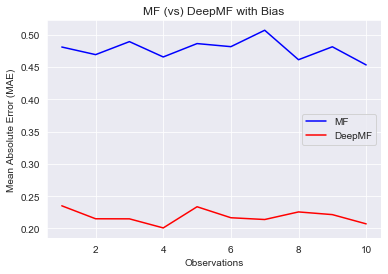

In [13]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,MAE_normalMF,color="b",label='MF')
plt.plot(x,MAE_DeepMF,color="r",label='DeepMF')
plt.title("MF (vs) DeepMF with Bias")
plt.xlabel("Observations")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()